In [3]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import classification_report, confusion_matrix
import cv2  # OpenCV library

# Step 1: Load and Preprocess the Data
train_dir = 'E:/p2/archive/train'
test_dir = 'E:/p2/archive/test'

# Set up the ImageDataGenerator for training and validation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    validation_split=0.2  # Use 20% of the training data for validation
)

# Set up the ImageDataGenerator for testing
test_datagen = ImageDataGenerator(rescale=1./255)

# Create the training, validation, and test generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    subset='training'  # Use this subset for training
)

validation_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical',
    subset='validation'  # Use this subset for validation
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=64,
    class_mode='categorical'
)

# Step 3: Build the Model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

# Step 4: Compile the Model
model.compile(optimizer=Adam(learning_rate=0.0001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Step 5: Train the Model
history = model.fit(
    train_generator,
    epochs=2, #50
    validation_data=validation_generator
)

# Step 6: Evaluate the Model
test_loss, test_acc = model.evaluate(test_generator)
print(f'Test accuracy: {test_acc}')

# Save the trained model
model.save('facial_expression_model.h5')


Found 22968 images belonging to 7 classes.
Found 5741 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.
Epoch 1/2
359/359 [==============================] - 267s 738ms/step - loss: 1.8373 - accuracy: 0.2391 - val_loss: 1.8597 - val_accuracy: 0.2513
Epoch 2/2
113/113 [==============================] - 71s 633ms/step - loss: 1.8392 - accuracy: 0.2580
Test accuracy: 0.258010596036911


113/113 [==============================] - 10s 85ms/step


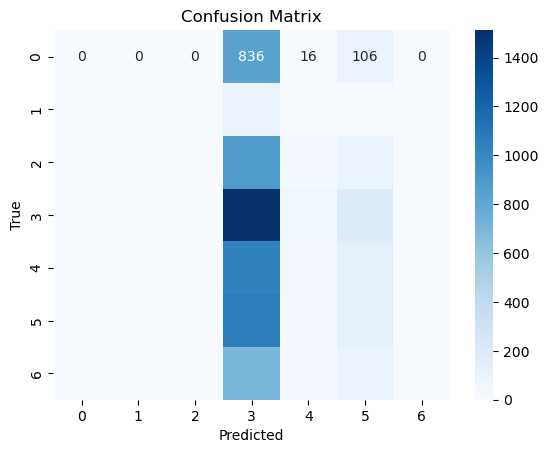

C:\Users\User\anaconda3\envs\tensorflowEnv_20240417\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\envs\tensorflowEnv_20240417\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\User\anaconda3\envs\tensorflowEnv_20240417\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier

              precision    recall  f1-score   support

       angry       0.00      0.00      0.00       958
     disgust       0.00      0.00      0.00       111
        fear       0.00      0.00      0.00      1024
       happy       0.25      0.85      0.38      1774
     neutral       0.20      0.04      0.06      1233
         sad       0.18      0.12      0.14      1247
    surprise       0.00      0.00      0.00       831

    accuracy                           0.24      7178
   macro avg       0.09      0.14      0.08      7178
weighted avg       0.13      0.24      0.13      7178

1/1 [==============================] - 0s 29ms/step


In [6]:
# Load the saved model
model = load_model('facial_expression_model.h5')

# Step 8: Confusion Matrix and Classification Report
y_pred = model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = test_generator.classes

conf_matrix = confusion_matrix(y_true, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

target_names = list(test_generator.class_indices.keys())
print(classification_report(y_true, y_pred_classes, target_names=target_names))

# Step 9: Real-Time Facial Expression Recognition

# Dictionary to map label indexes to emotion names
emotion_dict = {v: k for k, v in train_generator.class_indices.items()}

# Initialize webcam
cap = cv2.VideoCapture(0)

while True:
    # Capture frame-by-frame
    ret, frame = cap.read()
    
    if not ret:
        break
    
    # Convert the frame to grayscale
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    
    # Use OpenCV's built-in Haar cascade to detect faces
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, scaleFactor=1.3, minNeighbors=5)
    
    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+w, x:x+h]
        roi_gray = cv2.resize(roi_gray, (48, 48))
        roi_gray = roi_gray.astype('float32') / 255.0
        roi_gray = np.expand_dims(roi_gray, axis=0)
        roi_gray = np.expand_dims(roi_gray, axis=-1)
        
        # Predict the emotion
        prediction = model.predict(roi_gray)
        max_index = np.argmax(prediction[0])
        predicted_emotion = emotion_dict[max_index]
        
        # Draw rectangle around the face
        cv2.rectangle(frame, (x, y), (x+w, y+h), (255, 0, 0), 2)
        # Put the predicted emotion text above the rectangle
        cv2.putText(frame, predicted_emotion, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)
    
    # Display the resulting frame
    cv2.imshow('Facial Expression Recognition', frame)
    
    # Break the loop on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# When everything is done, release the capture
cap.release()
cv2.destroyAllWindows()
